In [2]:
import numpy as np
import pandas as pd
from sklearn import svm 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler # normalization
import matplotlib.pyplot as plt # plotting
from matplotlib import cm
import seaborn # plottin
from PIL import Image # image opening
import math
import os

In [3]:
# PLOTTING
def plot_array_as_image(X, m, n, is_1d=False):
    if is_1d:
        X = X.reshape((m, n))
    plt.figure(figsize=(8, 8))
    plt.imshow(X)

def plot_array_as_image_color(X, m, n, is_1d=False):
    if is_1d:
        X = np.array([np.linalg.norm(pixel_diff) for pixel_diff in X])
        X = X.reshape((m, n))

    plt.figure(figsize=(8, 8))
    plt.imshow(X)

    
def plot_deltas(count_deltas, p_value_ind):
    plt.figure(figsize=(8, 8))

    plt.plot(count_deltas, label='deltas based on frobenius norm', color='b')
    plt.axvline(x=p_value_ind, label='p_value_ind', color='r')
    plt.legend()
    plt.tight_layout()

In [4]:
class Data:
    # IMAGE SCANNING
    def scan_img_color(self, path_img1, path_img2):
        img1 = Image.open(path_img1)
        img2 = Image.open(path_img2)

        # take the difference between two images
        difference = np.array(img1, dtype=np.int16) - np.array(img2, dtype=np.int16)
        self.m, self.n, self.dim = difference.shape
        self.samples = self.m * self.n
        # reshape it
        difference = difference.reshape((self.samples, self.dim), order='C')
        # normalize them and save in X
        self.X = MinMaxScaler().fit_transform(difference)
        # now count norms for each pixel's difference
        self.norms = np.array([np.linalg.norm(pixel_diff) for pixel_diff in self.X])

        self.y = np.full(self.samples, False, dtype=bool)
        self.classify_changes(p_value=0.6, show_deltas=False, is_bw=False)
        plot_array_as_image(self.y, self.m, self.n, is_1d=True)

    def scan_img_bw(self, path_img1, path_img2):
        img1 = Image.open(path_img1).convert('L')
        img2 = Image.open(path_img2).convert('L')

        # take the difference between two images
        difference = np.array(img1, dtype=np.int16) - np.array(img2, dtype=np.int16)
        self.m, self.n = difference.shape
        self.samples = self.m * self.n
        # reshape it
        difference = difference.reshape((self.samples, 1), order='C')
        # normalize them and save in X
        self.X = MinMaxScaler().fit_transform(difference)
        self.norms = self.X

        # LABELS PART
        self.y = np.full(self.samples, False, dtype=bool)
        self.classify_changes(p_value=0.6, show_deltas=False, is_bw=True)
        plot_array_as_image(self.y, self.m, self.n, is_1d=True)
        plot_array_as_image(self.X, self.m, self.n, is_1d=True)

    def scan_dir_imgs_color(self, path_images1, path_images2, path_labels, m=512, n=512, dim=3, cnt_images=1, start_from=0):
        # suppose images are named the same in all 3 directories
        # We will use each pixel as a sample with dim features
        # Storing samples in X and labels in y

        img_filenames = os.listdir(path_images1)

        self.m, self.n, self.features = m, n, dim
        self.img_size = self.m * self.n
        self.cnt_images = cnt_images
        self.samples = cnt_images * self.img_size
        self.X = np.array([np.full(self.features, 0.0, dtype=np.float64) for i in range(self.samples)])
        self.y = np.full(self.samples, 0, dtype=np.int32)

        for im_ind in range(start_from, len(img_filenames)):
            im_offset = im_ind - start_from
            if im_offset % 10 == 0 or im_offset == cnt_images - 1:
                print("image no.", im_ind)
                print(img_filenames[im_ind])

            # IMAGES PART
            img1 = Image.open(path_images1 + "/" + img_filenames[im_ind])
            img2 = Image.open(path_images2 + "/" + img_filenames[im_ind])

            # take the difference between two images
            difference = np.array(img1, dtype=np.int16) - np.array(img2, dtype=np.int16)
            # reshape it
            difference = difference.reshape((self.img_size, self.features), order='C')
            # normalize them
            difference = MinMaxScaler().fit_transform(difference)

            # save pixel norms as features in X[im_ind]
            for pixel_ind in range(self.img_size):
                self.X[im_offset * self.img_size + pixel_ind] = difference[pixel_ind]
        
            # LABELS PART
            img_labels = Image.open(path_labels + "/" + img_filenames[im_ind]).convert('L')    
            pixel_labels = np.array(img_labels, dtype=np.int16).reshape((self.img_size, 1))

            # store bool(pixel_label)
            for pixel_ind in range(self.img_size):
                self.y[im_offset * self.img_size + pixel_ind] = np.sign(pixel_labels[pixel_ind] - 255)
        
            # stop criteria
            if im_offset == cnt_images - 1:
                break

    def scan_dir_imgs_bw(self, path_images1, path_images2, path_labels, m=512, n=512, cnt_images=1, start_from=0):
        # suppose images are named the same in all 3 directories
        # We will use each pixel as a sample with dim features
        # Storing samples in X and labels in y

        img_filenames = os.listdir(path_images1)

        self.m, self.n, self.features = m, n, 1
        self.img_size = self.m * self.n
        self.cnt_images = cnt_images
        self.samples = cnt_images * self.img_size
        self.X = np.array([np.full(self.features, 0.0, dtype=np.float64) for i in range(self.samples)])
        self.y = np.full(self.samples, 0, dtype=np.int32)

        for im_ind in range(start_from, len(img_filenames)):
            im_offset = im_ind - start_from
            if im_offset % 10 == 0 or im_offset == cnt_images - 1:
                print("image no.", im_ind)
                print(img_filenames[im_ind])

            # IMAGES PART
            img1 = Image.open(path_images1 + "/" + img_filenames[im_ind]).convert('L')
            img2 = Image.open(path_images2 + "/" + img_filenames[im_ind]).convert('L')

            # take the difference between two images
            difference = np.array(img1, dtype=np.int16) - np.array(img2, dtype=np.int16)
            # reshape it
            difference = difference.reshape((self.img_size, self.features), order='C')
            # normalize them
            difference = MinMaxScaler().fit_transform(difference)

            # save pixel norms as features in X[im_ind]
            for pixel_ind in range(self.img_size):
                self.X[im_offset * self.img_size + pixel_ind] = difference[pixel_ind]
        
            # LABELS PART
            img_labels = Image.open(path_labels + "/" + img_filenames[im_ind]).convert('L')    
            pixel_labels = np.array(img_labels, dtype=np.int16).reshape((self.img_size, 1))

            # store bool(pixel_label)
            for pixel_ind in range(self.img_size):
                self.y[im_offset * self.img_size + pixel_ind] = np.sign(pixel_labels[pixel_ind] - 255)
        
            # stop criteria
            if im_offset == cnt_images - 1:
                break


    # CLUSTERISATION
    def count_cluster(self, data, clusters, img_ind, ind1, ind2):
        img_offset_clusters = img_ind * self.clusters_per_image
        img_offset_data = img_ind * self.img_size

        for i in range(self.cluster_size * ind1, self.cluster_size * ind1 + self.cluster_size):
            for j in range(self.cluster_size * ind2, self.cluster_size * ind2 + self.cluster_size):
                clusters[img_offset_clusters + ind1 * self.n_clusters + ind2] += data[img_offset_data + i * self.n + j]
        clusters[img_offset_clusters + ind1 * self.n_clusters + ind2] /= self.clusters_per_image


    # assuming the image is n * n pixels and has 1 feature
    # and cluster_size divides n
    def clusterise_data(self, cluster_size=16):
        self.cluster_size = cluster_size
        self.n_clusters = int(self.n / cluster_size)
        self.clusters_per_image = self.n_clusters * self.n_clusters

        self.X_clusters = np.full((self.cnt_images * self.n_clusters * self.n_clusters, 1), 0.0, dtype=np.float64)
        self.y_clusters = np.full(self.cnt_images * self.n_clusters * self.n_clusters, 0.0, dtype=np.float64)
        
        for img_ind in range(self.cnt_images):
            for i in range(self.n_clusters):
                for j in range(self.n_clusters):
                    self.count_cluster(self.X, self.X_clusters, img_ind, i, j)
                    self.count_cluster(self.y, self.y_clusters, img_ind, i, j)
                    self.y_clusters = np.sign(self.y_clusters)
    
    
    def count_cluster_dim(self, data, clusters, img_ind, ind1, ind2):
        img_offset_clusters = img_ind * self.clusters_per_image
        img_offset_data = img_ind * self.img_size

        for i in range(self.cluster_size * ind1, self.cluster_size * ind1 + self.cluster_size):
            for j in range(self.cluster_size * ind2, self.cluster_size * ind2 + self.cluster_size):
                for f in range(self.features):
                    clusters[img_offset_clusters + ind1 * self.n_clusters + ind2][f] += data[img_offset_data + i * self.n + j][f]
        
        for f in range(self.features):
            clusters[img_offset_clusters + ind1 * self.n_clusters + ind2][f] /= self.clusters_per_image

    # assuming the image is n * n pixels and has 1 feature
    # and cluster_size divides n
    def clusterise_data_dim(self, cluster_size=16):
        self.cluster_size = cluster_size
        self.n_clusters = int(self.n / cluster_size)
        self.clusters_per_image = self.n_clusters * self.n_clusters

        self.X_clusters = np.full((self.cnt_images * self.n_clusters * self.n_clusters, self.features), 0.0, dtype=np.float64)
        self.y_clusters = np.full(self.cnt_images * self.n_clusters * self.n_clusters, 0.0, dtype=np.float64)
        
        for img_ind in range(self.cnt_images):
            for i in range(self.n_clusters):
                for j in range(self.n_clusters):
                    self.count_cluster_dim(self.X, self.X_clusters, img_ind, i, j)
                    self.count_cluster(self.y, self.y_clusters, img_ind, i, j)
                    self.y_clusters = np.sign(self.y_clusters)

    # def drop_p_values(self, p_value):
    #     for im_ind in self.cnt_images:
            

In [5]:
path_im1 = './data/SECOND_train_set/im1/'
path_im2 = './data/SECOND_train_set/im2/'
path_labels = './data/SECOND_train_set/label1/'

In [6]:
cnt_train_images = 16
DBW_train = Data()
DBW_train.scan_dir_imgs_bw(path_im1, path_im2, path_labels, m=512, n=512, cnt_images=cnt_train_images)

image no. 0
00003.png
image no. 10
00026.png
image no. 15
00038.png


In [7]:
DBW_train.clusterise_data(cluster_size=16)

In [8]:
cnt_test_images = 3
DBW_test = Data()
DBW_test.scan_dir_imgs_bw(path_im1, path_im2, path_labels, m=512, n=512, cnt_images=cnt_test_images, start_from=100)

image no. 100
00233.png
image no. 102
00242.png


In [9]:
DBW_test.clusterise_data(cluster_size=16)

In [10]:
clf_BW = svm.SVC(kernel='rbf', gamma='scale', C=0.1)
clf_BW.fit(DBW_train.X_clusters, DBW_train.y_clusters)

SVC(C=0.1)

In [11]:
clf_BW.score(DBW_test.X_clusters[:DBW_test.clusters_per_image], 
    DBW_test.y_clusters[:DBW_test.clusters_per_image])

0.6171875

In [12]:
yBW_test_predicted = clf_BW.predict(DBW_test.X_clusters[:DBW_test.clusters_per_image])

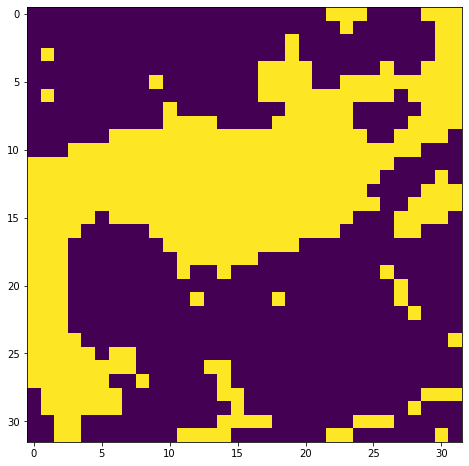

In [13]:
plot_array_as_image(DBW_test.y_clusters[:DBW_test.clusters_per_image],
    m=DBW_test.n_clusters, n=DBW_test.n_clusters, is_1d=True)

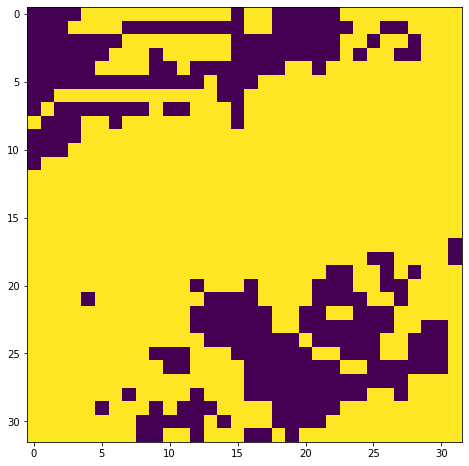

In [14]:
plot_array_as_image(yBW_test_predicted, m=DBW_test.n_clusters, n=DBW_test.n_clusters, is_1d=True)

In [15]:
kernels = ['rbf', 'poly']
gammas = ['scale', 'auto', 0.01, 0.1, 0.3, 0.5, 1, 10]
Cs = [0.001, 0.01, 0.1, 1, 10, 100]

average_scores = []
for kernel in kernels:
    for gamma in gammas:
        for C in Cs:
            clf_BW = svm.SVC(kernel=kernel, gamma=gamma, C=C)
            clf_BW.fit(DBW_train.X_clusters, DBW_train.y_clusters)
            print("kernel = {}, gamma = {}, C = {}".format(kernel, gamma, C))

            scores = [0.0, 0.0, 0.0]
            print("scores: ", end="")

            for i in range(cnt_test_images):
                scores[i] = clf_BW.score(
                    DBW_test.X_clusters[i * DBW_test.clusters_per_image : (i + 1) * DBW_test.clusters_per_image],
                    DBW_test.y_clusters[i * DBW_test.clusters_per_image : (i + 1) * DBW_test.clusters_per_image])
                print("{:.6f} ".format(scores[i]), end="")
            
            average_score = sum(scores) / cnt_test_images
            print("\naverage score: {:.6f}".format(average_score)) 
            average_scores.append(average_score)            

kernel = rbf, gamma = scale, C = 0.001
scores: 0.532227 0.824219 0.535156 
average score: 0.630534
kernel = rbf, gamma = scale, C = 0.01
scores: 0.605469 0.793945 0.583008 
average score: 0.660807
kernel = rbf, gamma = scale, C = 0.1
scores: 0.617188 0.782227 0.581055 
average score: 0.660156
kernel = rbf, gamma = scale, C = 1
scores: 0.611328 0.788086 0.581055 
average score: 0.660156
kernel = rbf, gamma = scale, C = 10
scores: 0.612305 0.787109 0.580078 
average score: 0.659831
kernel = rbf, gamma = scale, C = 100
scores: 0.617188 0.779297 0.581055 
average score: 0.659180
kernel = rbf, gamma = auto, C = 0.001
scores: 0.386719 0.833008 0.483398 
average score: 0.567708
kernel = rbf, gamma = auto, C = 0.01
scores: 0.386719 0.833008 0.483398 
average score: 0.567708
kernel = rbf, gamma = auto, C = 0.1
scores: 0.386719 0.833008 0.483398 
average score: 0.567708
kernel = rbf, gamma = auto, C = 1
scores: 0.386719 0.833008 0.483398 
average score: 0.567708
kernel = rbf, gamma = auto, C = 1

In [17]:
clf_BW = svm.SVC(kernel='rbf', gamma=10, C=100)
clf_BW.fit(DBW_train.X_clusters, DBW_train.y_clusters)
print("kernel = {}, gamma = {}, C = {}".format('rbf', 10, 100))

scores = [0.0, 0.0, 0.0]
print("scores: ", end="")

for i in range(cnt_test_images):
    scores[i] = clf_BW.score(
        DBW_test.X_clusters[i * DBW_test.clusters_per_image : (i + 1) * DBW_test.clusters_per_image],
        DBW_test.y_clusters[i * DBW_test.clusters_per_image : (i + 1) * DBW_test.clusters_per_image])
    print("{:.6f} ".format(scores[i]), end="")

average_score = sum(scores) / cnt_test_images
print("\naverage score: {:.6f}".format(average_score))       

kernel = rbf, gamma = 10, C = 100
scores: 0.535156 0.823242 0.554688 
average score: 0.637695


In [18]:
yBW_test_predicted_2 = clf_BW.predict(DBW_test.X_clusters[:DBW_test.clusters_per_image])

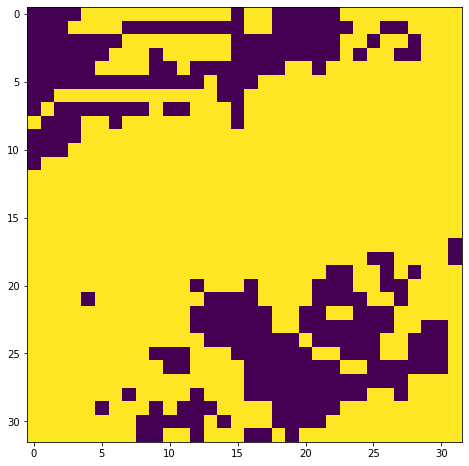

In [21]:
plot_array_as_image(yBW_test_predicted, m=DBW_test.n_clusters, n=DBW_test.n_clusters, is_1d=True)

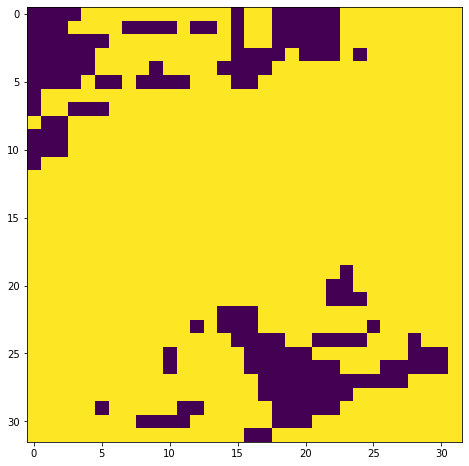

In [20]:
plot_array_as_image(yBW_test_predicted_2, m=DBW_test.n_clusters, n=DBW_test.n_clusters, is_1d=True)

In [23]:
class SVM_Change_Detection_Classifier:
    def get_images(self, path_im1, path_im2, path_labels, cnt_train_images, 
        cnt_test_images, start_from_train=0, start_from_test=100, color=False, cluster_size=8):

        self.D_train = Data()
        if color:
            self.D_train.scan_dir_imgs_color(path_im1, path_im2, path_labels, 
                cnt_images=cnt_train_images, start_from=start_from_train)
        else:
            self.D_train.scan_dir_imgs_bw(path_im1, path_im2, path_labels,
                cnt_images=cnt_train_images, start_from=start_from_train)
        
        self.D_train.clusterise_data(cluster_size=cluster_size)

        self.D_test = Data()
        if color:
            self.D_test.scan_dir_imgs_color(path_im1, path_im2, path_labels, 
                cnt_images=cnt_test_images, start_from=start_from_test)
        else:
            self.D_test.scan_dir_imgs_bw(path_im1, path_im2, path_labels, 
                cnt_images=cnt_test_images, start_from=start_from_test)
        
        self.D_test.clusterise_data(cluster_size=cluster_size)

    def train(self):
        self.clf = svm.SVC(kernel='rbf', gamma='scale', C=0.1)
        self.clf.fit(self.D_train.X_clusters, self.D_train.y_clusters)
    
    def correct_labels(self, test_image_ind=0):
        i = test_image_ind * self.D_test.clusters_per_image
        j = (test_image_ind + 1) * self.D_test.clusters_per_image
        return self.D_test.y_clusters[i:j]
    
    def predict_labels(self, test_image_ind=0):
        i = test_image_ind * self.D_test.clusters_per_image
        j = (test_image_ind + 1) * self.D_test.clusters_per_image
        return self.clf.predict(self.D_test.X_clusters[i:j])

In [30]:
S_ = SVM_Change_Detection_Classifier()
S_.get_images(path_im1, path_im2, path_labels, cnt_train_images=16, cnt_test_images=10,
    start_from_train=0, start_from_test=120, cluster_size=16)
S_.train()

image no. 0
00003.png
image no. 10
00026.png
image no. 15
00038.png
image no. 120
00291.png
image no. 129
00319.png


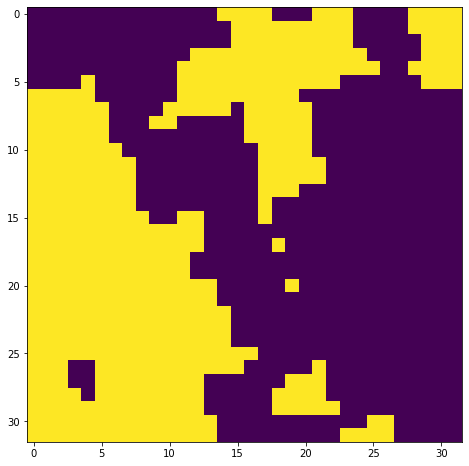

In [40]:
plot_array_as_image(S_.correct_labels(4), m=S_.D_test.n_clusters, n=S_.D_test.n_clusters, is_1d=True)

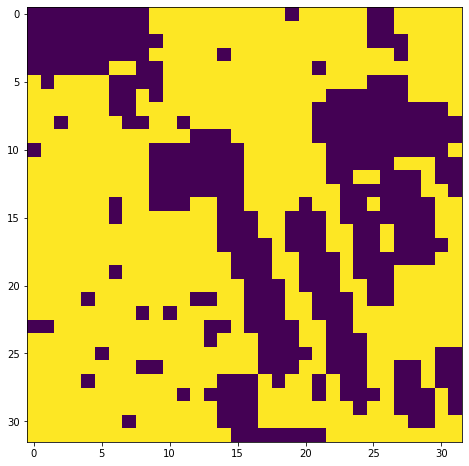

In [39]:
plot_array_as_image(S_.predict_labels(4), m=S_.D_test.n_clusters, n=S_.D_test.n_clusters, is_1d=True)

In [42]:
y_correct = S_.correct_labels(0).reshape((S_.D_test.n_clusters, S_.D_test.n_clusters))
fig = plt.figure(1, (8, 8))
plt.imshow(y_correct)
plt.savefig('correct.png')
plt.close(fig)

y_predict = S_.predict_labels(0).reshape((S_.D_test.n_clusters, S_.D_test.n_clusters))
fig = plt.figure(1, (8, 8))
plt.imshow(y_predict)
plt.savefig('predict.png')
plt.close(fig)
